# Community detection in large open-source projects

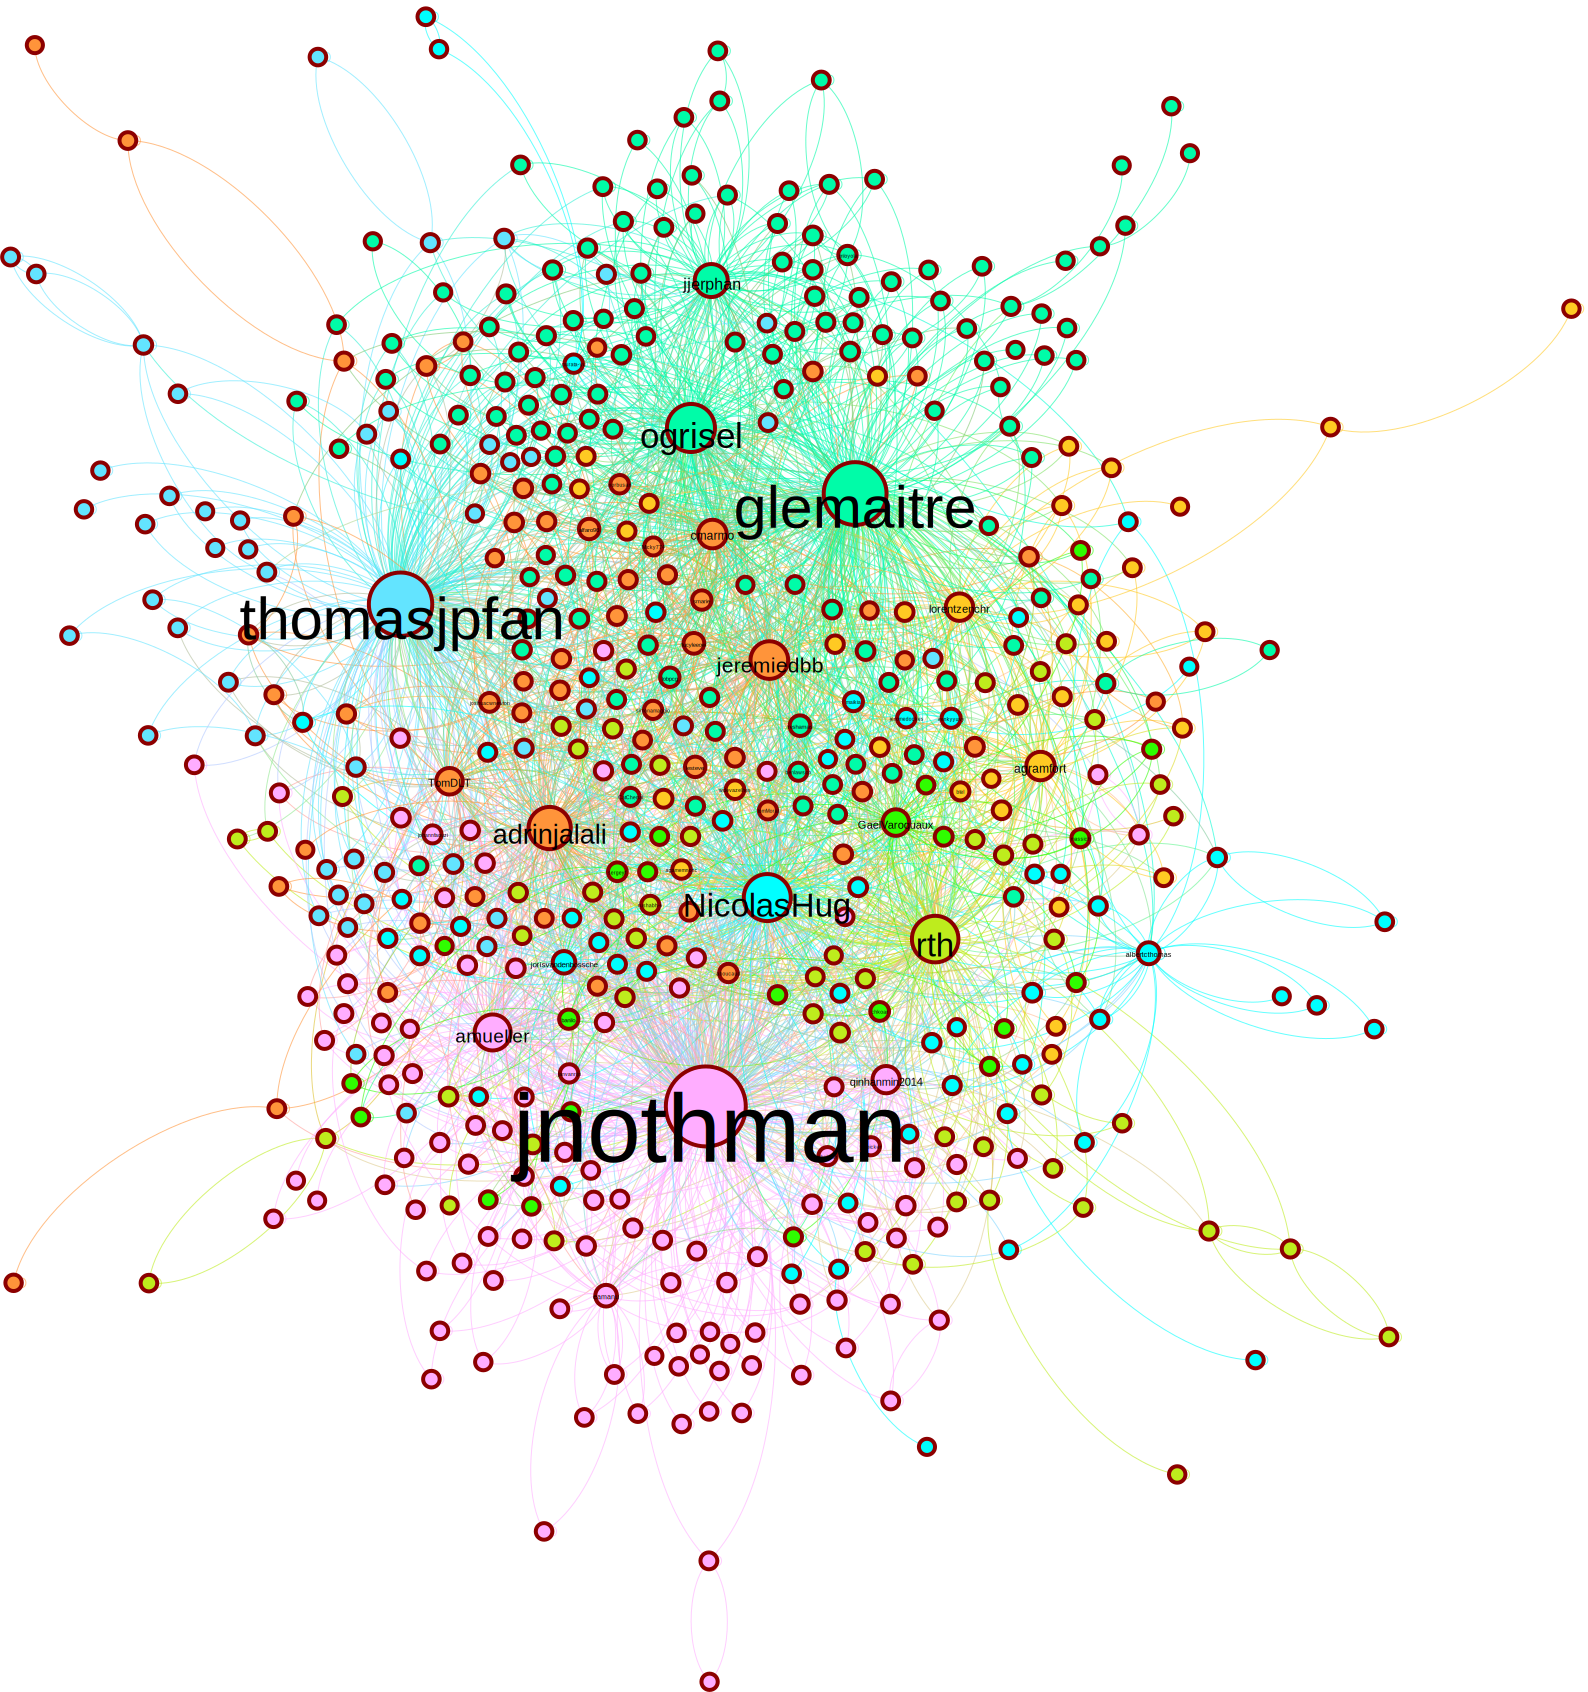

In [1]:
import networkx as nx
from IPython.display import SVG, display

display(SVG(filename='./scikit_graph.svg'))

## Prerequisites

1. Install requirements

In [2]:
# !pip install -r requirements.txt

2. You also need a [PostgreSQL](https://www.postgresql.org/download/) database instance if you want to parse your own copy of the dataset
3. And a GitHub account with a [GitHub token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)

## Data

The dataset used in the project is composed of Pull Requests from scikit-learn repository and associated communication between reviewers and authors.

Data was collected from [Pull Requests in scikit-learn repository](https://github.com/scikit-learn/scikit-learn/pulls?q=is%3Apr+is%3Aopen+comments%3A%3E20) using [GitHub GraphQL API](https://docs.github.com/en/graphql).

### Database

All data is stored in PostgreSQL database using SQLAlchemy ORM. To initialize database run following command:

In [3]:
# !python -m db -c <your connection string>

### Parsing

To parse pull requests:

In [4]:
# !python -m parse -c <your connection string> -t <your GitHub token> -o scikit-learn -r scikit-learn

### Data overview

In [5]:
%load_ext dotenv
%dotenv

In [7]:
import os
from db.session import connect

Session = connect(os.getenv('PG_CONN'))

In [8]:
from db.models import Request

print('Number of pull requests: {0}'.format(Session.query(Request).count()))

Number of pull requests: 990


In [9]:
from db.models import Review

print('Number of reviews: {0}'.format(Session.query(Review).count()))

Number of reviews: 18905


In [10]:
from db.models import Comment

print('Number of comments: {0}'.format(Session.query(Comment).count()))

Number of comments: 29077


In [31]:
from db.models import User

print('Number of contributors: {0}'.format(Session.query(User).count()))

Number of contributors: 509


## Network analysis

### Summary

Since this is a communication network, the resulting graph is a directional homogeneous graph unweighted graph with self loops.
All nodes are collaborators to scikit-learn repository.
Edges represent communication between them.

In [11]:
from network import get_graph

g = get_graph()

# leave only the gigantic component
gcc = sorted([c for c in nx.connected_components(g.to_undirected())], key=lambda x: len(x), reverse=True)[0]

g = g.subgraph(gcc)

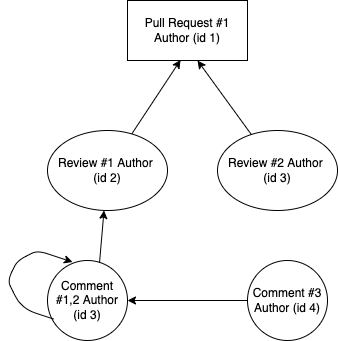

In [12]:
from IPython.display import Image, display

display(Image(filename='communication_diagram.png'))

For example, the diagram above will result in following graph:

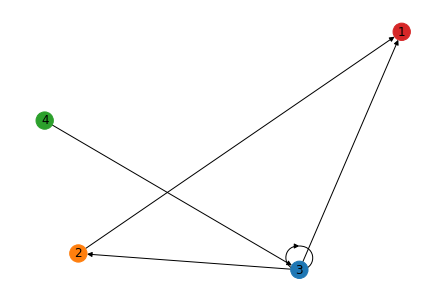

In [13]:
dg = nx.MultiDiGraph()

dg.add_nodes_from(range(1, 5))
dg.add_edges_from([(3, 1), (2, 1), (4, 3), (3, 3), (3, 2)])

node_color = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green']

nx.draw(dg, with_labels=True, node_color=node_color)

In [14]:
print('Number of nodes: ', g.number_of_nodes())

Number of nodes:  503


In [15]:
print('Number of edges: ', g.number_of_edges())

Number of edges:  3182


In [16]:
print('Diameter: ', nx.diameter(g.to_undirected()))

Diameter:  6


In [17]:
print('Radius: ', nx.radius(g.to_undirected()))

Radius:  3


In [21]:
print('Average clustering coefficient: %.5f' % nx.average_clustering(g.to_undirected()))

Average clustering coefficient: 0.76663


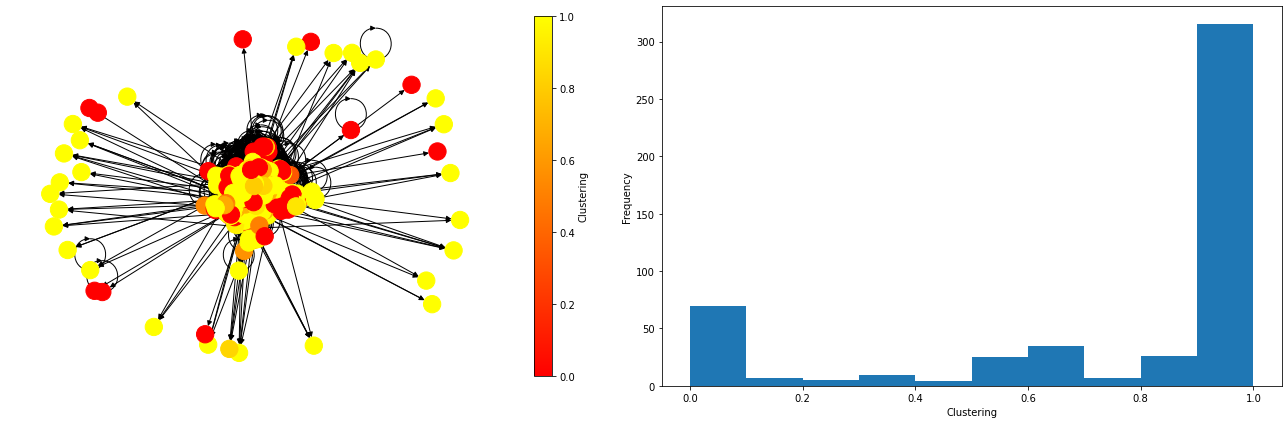

In [24]:
# Based on https://stackoverflow.com/a/64491257

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import networkx as nx

lcc = nx.clustering(g.to_undirected())

cmap = plt.get_cmap('autumn')
norm = plt.Normalize(0, max(lcc.values()))
node_colors = [cmap(norm(lcc[node])) for node in g.nodes]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
nx.draw_spring(g, node_color=node_colors, with_labels=False, ax=ax1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), label='Clustering', shrink=0.95, ax=ax1)

ax2.hist(lcc.values(), bins=10)
ax2.set_xlabel('Clustering')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [26]:
print('Average path length: %.5f' % nx.average_shortest_path_length(g))

Average path length: 2.21121
